In [4]:
#Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import numpy as np
import pandas as pd
df = pd.read_csv("rainfall.csv")

df_wind = df.copy()

# Convert wind direction from degrees to radians
df_wind['wind_dir_rad'] = np.deg2rad(df_wind['winddir'])

# Create sine and cosine components
df_wind['wind_sin'] = np.sin(df_wind['wind_dir_rad'])
df_wind['wind_cos'] = np.cos(df_wind['wind_dir_rad'])

In [6]:
features = ['temp', 'humidity']
X = df_wind[features]

# Targets: sin and cos components
y_sin = df_wind['wind_sin']
y_cos = df_wind['wind_cos']

In [7]:
X_train, X_test, y_sin_train, y_sin_test, y_cos_train, y_cos_test = train_test_split(
    X, y_sin, y_cos, test_size=0.2, random_state=42
)

In [8]:
from sklearn.ensemble import RandomForestRegressor

# Train separate models
model_sin = RandomForestRegressor()
model_cos = RandomForestRegressor()

model_sin.fit(X_train, y_sin_train)
model_cos.fit(X_train, y_cos_train)

# Predict
y_sin_pred = model_sin.predict(X_test)
y_cos_pred = model_cos.predict(X_test)

# Reconstruct angle in degrees
y_pred_angle = (np.degrees(np.arctan2(y_sin_pred, y_cos_pred)) + 360) % 360

# Same for true values (for evaluation)
y_true_angle = (np.degrees(np.arctan2(y_sin_test, y_cos_test)) + 360) % 360

In [9]:
# Angular error
angle_errors = np.abs(y_true_angle - y_pred_angle)
angle_errors = np.minimum(angle_errors, 360 - angle_errors)  # Wrap-around correction

mae = np.mean(angle_errors)
print("Wind Direction MAE (in degrees):", mae)

Wind Direction MAE (in degrees): 36.92102213082426


Wind Direction MAE (in degrees): 36.92
Wind Direction RMSE: 47.23
Wind Direction R² Score: -0.11


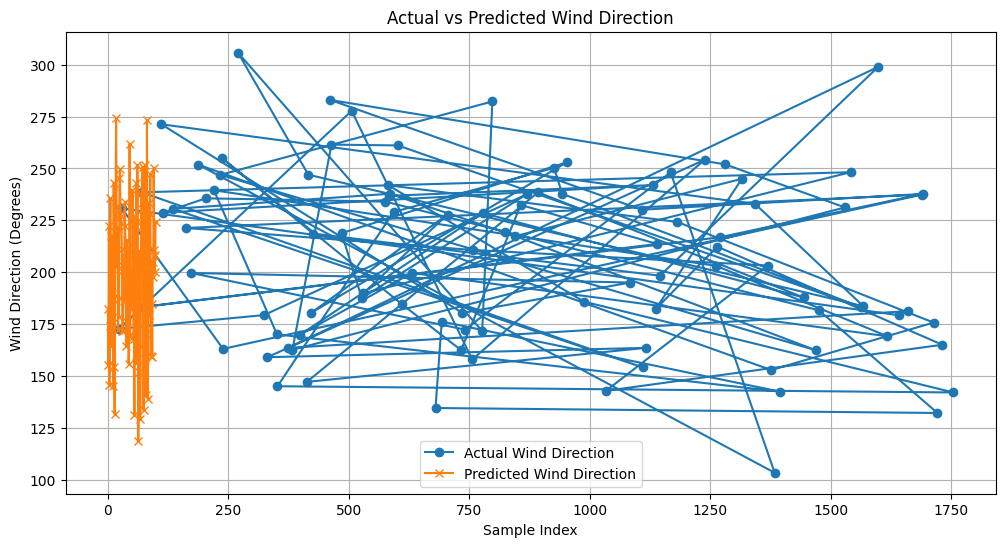

In [10]:
#wind dir
mae = mean_absolute_error(y_true_angle, y_pred_angle)
rmse = np.sqrt(mean_squared_error(y_true_angle, y_pred_angle))

# Custom R2
r2 = r2_score(y_true_angle, y_pred_angle)

print(f"Wind Direction MAE (in degrees): {mae:.2f}")
print(f"Wind Direction RMSE: {rmse:.2f}")
print(f"Wind Direction R² Score: {r2:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(y_true_angle[:100], label='Actual Wind Direction', marker='o')
plt.plot(y_pred_angle[:100], label='Predicted Wind Direction', marker='x')
plt.ylabel('Wind Direction (Degrees)')
plt.xlabel('Sample Index')
plt.title('Actual vs Predicted Wind Direction')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
print("Predicted degrees (first 20):", y_pred_angle[:20])
print("Actual degrees (first 20):", y_true_angle[:20])

Predicted degrees (first 20): [182.26321911 155.05047121 222.23052603 145.63612988 173.84942788
 235.51550602 164.2122538  217.60085881 189.31639238 206.72418587
 187.01698146 145.1261092  243.17229395 154.30518695 131.42971525
 219.16728542 231.17046654 274.48580563 232.01071176 203.0219619 ]
Actual degrees (first 20): 824     219.3
1470    162.3
233     246.9
798     282.3
777     171.6
270     305.8
416     247.0
1568    183.6
1344    232.8
111     271.3
736     180.3
1084    195.0
173     199.6
741     172.3
1168    248.1
1384    103.3
188     251.8
1377    152.8
1714    175.7
1182    224.2
dtype: float64


In [12]:
# Sort the data
df = df.sort_values('datetime').reset_index(drop=True)

# Create lag features
df['winddir_lag1'] = df['winddir'].shift(1)
df['winddir_lag2'] = df['winddir'].shift(2)

# Drop rows with NaNs from lagging
df = df.dropna().reset_index(drop=True)

# Define X and y
X = df[['winddir_lag1', 'winddir_lag2']]
y = df['winddir']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

# Predict
y_pred = xgb_model.predict(X_test)



Wind Direction MAE (in degrees): 35.86
Wind Direction RMSE: 45.62
Wind Direction R² Score: -0.04


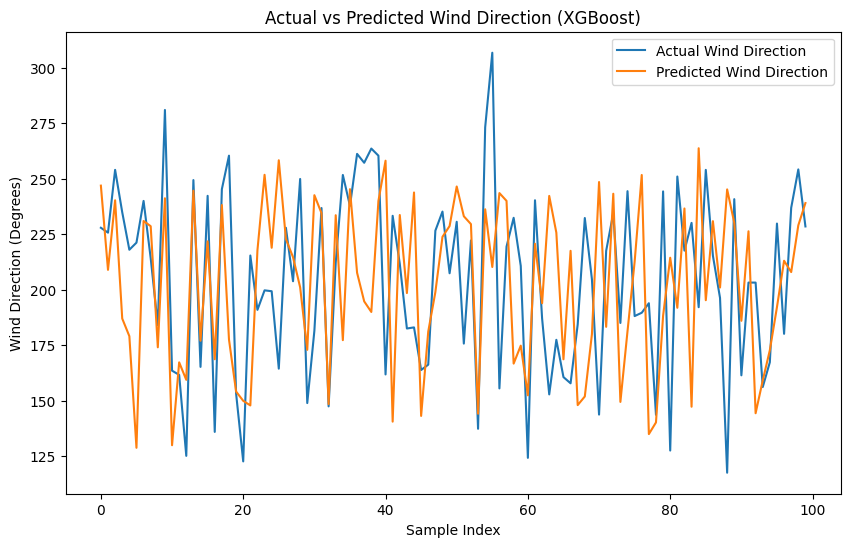

In [13]:
# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Wind Direction MAE (in degrees): {mae:.2f}")
print(f"Wind Direction RMSE: {rmse:.2f}")
print(f"Wind Direction R² Score: {r2:.2f}")

plt.figure(figsize=(10,6))
plt.plot(y_test[:100].values, label='Actual Wind Direction')
plt.plot(y_pred[:100], label='Predicted Wind Direction')
plt.xlabel('Sample Index')
plt.ylabel('Wind Direction (Degrees)')
plt.title('Actual vs Predicted Wind Direction (XGBoost)')
plt.legend()
plt.show()

In [14]:
df_lgb = df.sort_values('datetime').reset_index(drop=True)

# Create lag features
df_lgb['winddir_lag1'] = df_lgb['winddir'].shift(1)
df_lgb['winddir_lag2'] = df_lgb['winddir'].shift(2)

# Drop rows with NaN from lagging
df_lgb = df_lgb.dropna().reset_index(drop=True)

# Drop datetime column for modeling
df_lgb = df_lgb.drop(columns=['datetime'])

# Split into features and target
X = df_lgb.drop(columns=['winddir'])  # Make sure original winddir is NOT in features
y = df_lgb['winddir']

In [15]:
# Train-test split
split_index = int(0.8 * len(X))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Train LightGBM
lgb_model = lgb.LGBMRegressor(
    max_depth=5,
    num_leaves=20,
    min_data_in_leaf=30,
    learning_rate=0.05,
    n_estimators=200,
    lambda_l2=1.0,
    random_state=42
)
lgb_model.fit(X_train, y_train)

# Predict
y_pred_lgbm = lgb_model.predict(X_test)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1516
[LightGBM] [Info] Number of data points in the train set: 1421, number of used features: 10
[LightGBM] [Info] Start training from score 200.764110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [16]:
# Evaluate
mae = mean_absolute_error(y_test, y_pred_lgbm)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
r2 = r2_score(y_test, y_pred_lgbm)

print(f"LightGBM Wind Direction MAE (°): {mae:.2f}")
print(f"LightGBM Wind Direction RMSE: {rmse:.2f}")
print(f"LightGBM Wind Direction R² Score: {r2:.2f}")

LightGBM Wind Direction MAE (°): 24.24
LightGBM Wind Direction RMSE: 30.58
LightGBM Wind Direction R² Score: 0.52


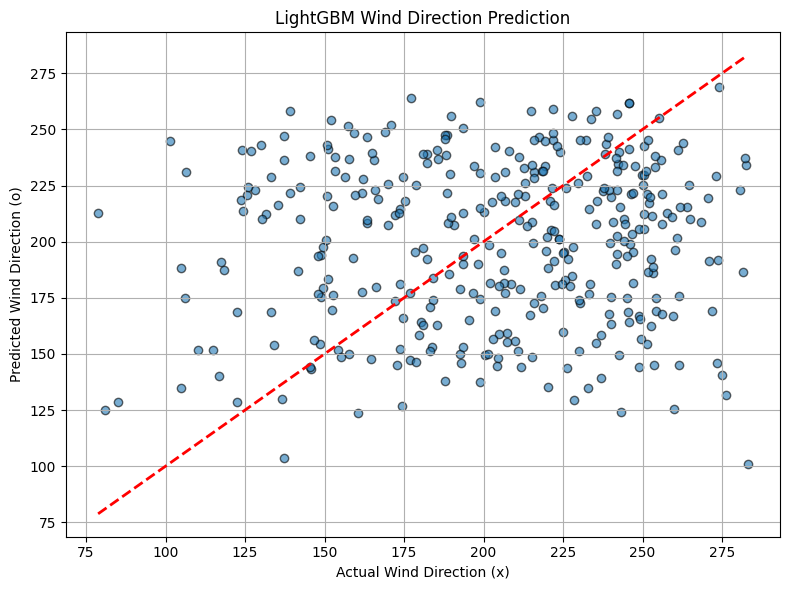

In [17]:
# Convert to Series and align lengths
y_test_series = pd.Series(y_test).reset_index(drop=True)
y_pred_series = pd.Series(y_pred).reset_index(drop=True)

# Align to minimum length
min_len = min(len(y_test_series), len(y_pred_series))
y_test_series = y_test_series[:min_len]
y_pred_series = y_pred_series[:min_len]

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_series, y_pred_series, alpha=0.6, edgecolors='k')
plt.plot([y_test_series.min(), y_test_series.max()], [y_test_series.min(), y_test_series.max()], 'r--', lw=2)
plt.xlabel('Actual Wind Direction (x)')
plt.ylabel('Predicted Wind Direction (o)')
plt.title('LightGBM Wind Direction Prediction')
plt.grid(True)
plt.tight_layout()
plt.show()

CatBoost Wind Direction MAE (°): 24.76
CatBoost Wind Direction RMSE: 31.11
CatBoost Wind Direction R² Score: 0.50


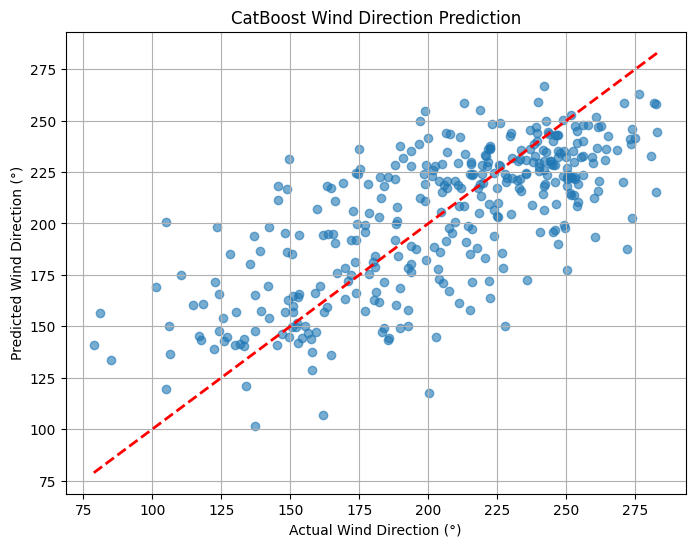

In [20]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Train CatBoost
cat_model = CatBoostRegressor(verbose=0, random_state=42)
cat_model.fit(X_train, y_train)

# Predict
y_pred = cat_model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"CatBoost Wind Direction MAE (°): {mae:.2f}")
print(f"CatBoost Wind Direction RMSE: {rmse:.2f}")
print(f"CatBoost Wind Direction R² Score: {r2:.2f}")

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.title("CatBoost Wind Direction Prediction")
plt.xlabel("Actual Wind Direction (°)")
plt.ylabel("Predicted Wind Direction (°)")
plt.grid(True)
plt.show()


In [22]:
from scipy.stats import spearmanr

corr, _ = spearmanr(y_test, y_pred)
print(f"Spearman Correlation (Trend Fit): {corr:.2f}")

Spearman Correlation (Trend Fit): 0.69


Of the models evaluated, CatBoost demonstrated superior performance across all metrics, achieving the lowest MAE and RMSE, and the highest R² score of 0.50. This result suggests a better fit to the underlying directional trends in the data, despite the inherent challenges of modeling circular variables.